In [7]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.io
from network_revised import Inputs_TwoDots, build_network

In [2]:
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

In [98]:
def make_palmer_dataframe():
    # convert original matlab files from Palmer et al 2005 into a single pandas dataframe
    names = ['JP', 'AH']
    dfs = []
    for i, filename in enumerate(['data/e12jp_bytrial.mat', 'data/e12ah_bytrial.mat']):
        f = scipy.io.loadmat(filename)
        emp = f['Data']
        df = pd.DataFrame({
                'name': [names[i] for j in range(len(emp[:,0]))],
                'trial': emp[:,7-1],
                'coherence': emp[:,22-1]/10,
                'goodtrial': emp[:,20-1],
                'accuracy': emp[:,14-1]*100,
                'RT': emp[:,15-1],
                'condition': emp[:,26-1]
            })
        data = df.query("goodtrial==1")
        data.loc[data["condition"] == 1.0, "condition"] = "speed"
        data.loc[data["condition"] == 2.0, "condition"] = "normal"
        data.loc[data["condition"] == 3.0, "condition"] = "accuracy"
        dfs.append(data)
    palmer = pd.concat(dfs, ignore_index=True)
    palmer = palmer.drop(columns=['goodtrial'])
    palmer.to_pickle("data/palmer2005.pkl")
    return palmer
# palmer = make_palmer_dataframe()
# print(palmer)

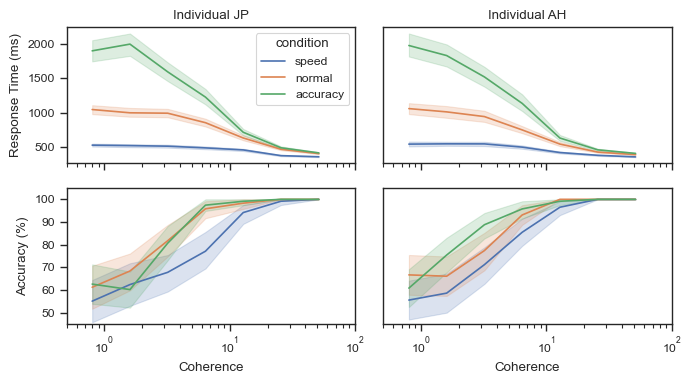

In [100]:
def plot_palmer():
    palmer = pd.read_pickle('data/palmer2005.pkl')
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=((7.08, 4)))
    sns.lineplot(data=palmer.query("name=='JP'"), x='coherence', y='RT', hue='condition', ax=axes[0][0])
    sns.lineplot(data=palmer.query("name=='AH'"), x='coherence', y='RT', hue='condition', ax=axes[0][1])
    sns.lineplot(data=palmer.query("name=='JP'"), x='coherence', y='accuracy', hue='condition', ax=axes[1][0])
    sns.lineplot(data=palmer.query("name=='AH'"), x='coherence', y='accuracy', hue='condition', ax=axes[1][1])
    axes[0][0].set_xscale('log')
    axes[0][0].set(ylabel="Response Time (ms)", title="Individual JP")
    axes[0][1].set(ylabel=None, yticks=(()), title="Individual AH")
    axes[1][0].set(xlabel="Coherence", xlim=((0.5, 100)), ylabel="Accuracy (%)", ylim=((45, 105)), yticks=((50, 60, 70, 80, 90, 100)))
    axes[1][1].set(xlabel="Coherence", xlim=((0.5, 100)), ylabel=None, ylim=((45, 105)), yticks=(()))
    axes[0][1].get_legend().remove()
    axes[1][0].get_legend().remove()
    axes[1][1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/palmer2005.svg")
    fig.savefig(f"plots/palmer2005.png", dpi=600)
plot_palmer()

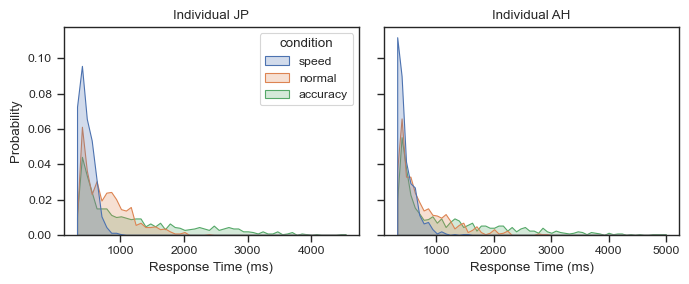

In [80]:
def plot_palmer2():
    palmer = pd.read_pickle('data/palmer2005.pkl')
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((7.08, 3)))
    sns.histplot(data=palmer.query("name=='JP'"), x='RT', hue='condition', stat='probability', element="poly", ax=axes[0])
    sns.histplot(data=palmer.query("name=='AH'"), x='RT', hue='condition', stat='probability', element="poly", ax=axes[1])
    axes[0].set(ylabel="Probability", xlabel="Response Time (ms)", title="Individual JP")
    axes[1].set(xlabel="Response Time (ms)", title="Individual AH")
    axes[1].get_legend().remove()
    plt.tight_layout()
    fig.savefig(f"plots/palmer2005_distributions.svg")
    fig.savefig(f"plots/palmer2005_distributions.png", dpi=600)
plot_palmer2()

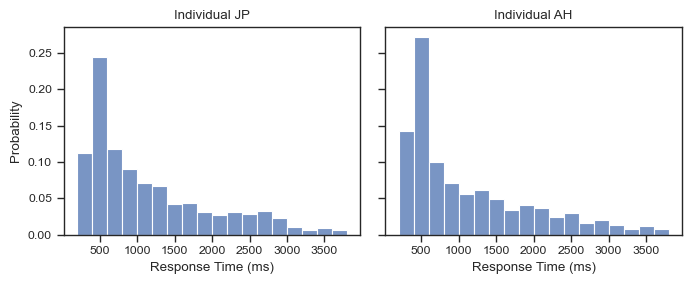

In [93]:
palmer = pd.read_pickle('data/palmer2005.pkl')
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((7.08, 3)))
sns.histplot(data=palmer.query("name=='JP' & condition=='accuracy'"), x='RT', stat='probability', bins=np.arange(200, 4000, 200), ax=axes[0])
sns.histplot(data=palmer.query("name=='AH' & condition=='accuracy'"), x='RT', stat='probability', bins=np.arange(200, 4000, 200), ax=axes[1])
axes[0].set(ylabel="Probability", xlabel="Response Time (ms)", title="Individual JP")
axes[1].set(xlabel="Response Time (ms)", title="Individual AH")
plt.tight_layout()

In [60]:
def single_trial(coherence, perception_seed=0, network_seed=0, dt=0.001, dt_sample=None, legend=False, name="single_trial", **kwargs):
    inputs = Inputs_TwoDots(dt_sample=dt_sample, seed=perception_seed)
    inputs.create(coherence=coherence)
    net = build_network(inputs, seed=network_seed, **kwargs)
    sim = nengo.Simulator(net, progress_bar=False)
    choice = None
    while choice==None:
        sim.run(dt)
        if sim.data[net.pAction][-1,0] > 0:
            choice = "L"
            RT = sim.trange()[-1]
        elif sim.data[net.pAction][-1,1] > 0:
            choice = "R"
            RT = sim.trange()[-1]
        if sim.trange()[-1] > 10:
            break
    is_correct = True if choice==inputs.correct else False
    idealL = sim.trange()/dt * net.inputs.L * net.ramp * dt
    idealR = sim.trange()/dt * net.inputs.R * net.ramp * dt

    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((7.08, 4)))
    axes[0].plot(sim.trange(), sim.data[net.pAccumulator][:,0], color=palette[0], label="evidence L") 
    axes[0].plot(sim.trange(), sim.data[net.pAccumulator][:,1], color=palette[1], label='evidence R') 
    if dt_sample is not None:
        axes[0].plot(sim.trange(), idealL, color=palette[0], label="true L", linestyle="--") 
        axes[0].plot(sim.trange(), idealR, color=palette[1], label='true R', linestyle="--") 
    axes[1].plot(sim.trange(), sim.data[net.pValue][:,0], color=palette[0], label="value L") 
    axes[1].plot(sim.trange(), sim.data[net.pValue][:,1], color=palette[1], label='value R') 
    axes[1].plot(sim.trange(), sim.data[net.pGate], label='threshold', color=palette[4])
    axes[0].set(ylabel=r"$\mathbf{\hat{x}}(t)$", title="Evidence in Accumulator")
    axes[1].set(xlabel="Time (s)", ylabel=r"$\mathbf{\hat{x}}(t)$", title="Decision Criteria")
    
    if legend:
        axes[0].legend(loc='upper left', ncol=2)
        leg = axes[1].legend(loc='upper left', ncol=1)
        if choice=="L":
            leg.get_texts()[0].set_color("lime" if is_correct else "red")
        if choice=="R":
            leg.get_texts()[1].set_color("lime" if is_correct else "red")
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

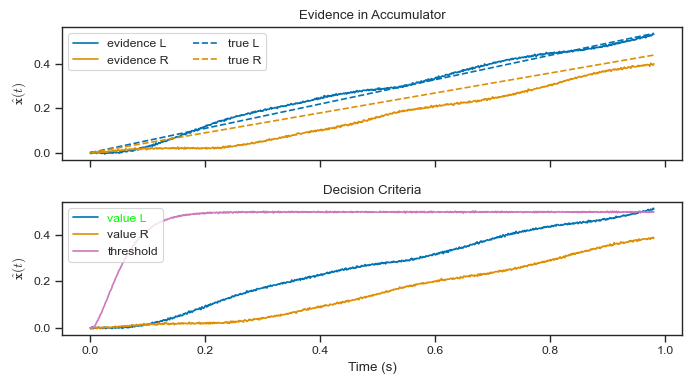

In [6]:
single_trial(coherence=0.1, threshold=0.5, perception_seed=1, dt_sample=0.02, legend=True)

In [7]:
def multiple_trial(coherence,
                   trials=3,
                   perception_seed=0,
                   network_seed=0,
                   dt=0.001,
                   dt_sample=0.02,
                   ramp=1,
                   threshold=0.5,
                   relative=0,
                   name="multiple_trials"):
    
    inputs = Inputs_TwoDots(dt_sample=dt_sample, seed=perception_seed)
    inputs.create(coherence=coherence)

    dfs_dynamics = []
    for trial in range(trials):
        print(f"trial {trial}, coherence {coherence}")
        net = build_network(inputs, seed=network_seed+trial, ramp=ramp, threshold=threshold, relative=relative)
        sim = nengo.Simulator(net, progress_bar=False)
        choice = None
        while choice==None:
            sim.run(dt)
            if sim.data[net.pAction][-1,0] > 0:
                choice = "L"
                RT = sim.trange()[-1]
            elif sim.data[net.pAction][-1,1] > 0:
                choice = "R"
                RT = sim.trange()[-1]
            elif sim.trange()[-1] > 5:
                choice = "L" if sim.data[net.pValue][-1,0] > sim.data[net.pValue][-1,1] else "R"
                RT = sim.trange()[-1]
        correct = True if choice==inputs.correct else False
        dfs_dynamics.append(pd.DataFrame({
            'coherence': coherence*np.ones_like(sim.trange()),
            'trial': trial*np.ones_like(sim.trange()),
            'time':sim.trange(),
            'ideal L':sim.trange()/dt * net.inputs.L * net.ramp * dt,
            'ideal R':sim.trange()/dt * net.inputs.R * net.ramp * dt,
            'evidence L':sim.data[net.pAccumulator][:,0].ravel(),
            'evidence R':sim.data[net.pAccumulator][:,1].ravel(),
            'value L':sim.data[net.pValue][:,0].ravel(),
            'value R':sim.data[net.pValue][:,1].ravel(),
            'gate':sim.data[net.pGate].ravel(),
            'correct':correct*1.0*np.ones_like(sim.trange()),
            'RT':RT*1.0*np.ones_like(sim.trange()),
        }))

    data = pd.concat(dfs_dynamics, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")
                            
    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((7.08, 3)))
    sns.lineplot(data=data, x='time', y='value L', units='trial', estimator=None, lw=0.2, color=palette[0], ax=axes[0])
    sns.lineplot(data=data, x='time', y='ideal L', linestyle="--", lw=2, color=palette[0], ax=axes[0])
    sns.lineplot(data=data, x='time', y='value R', units='trial', estimator=None, lw=0.2, color=palette[1], ax=axes[1])
    sns.lineplot(data=data, x='time', y='ideal R', linestyle="--", lw=2, color=palette[1], ax=axes[1])
    sns.lineplot(data=data, x='time', y='gate', color=palette[4], ax=axes[0])
    sns.lineplot(data=data, x='time', y='gate', color=palette[4], ax=axes[1])
    ymax = data['gate'].max()+0.05
    if inputs.correct=="L":
        axes[0].set(xlabel="Time (s)", ylabel=r"$\hat{\mathbf{x}}(t)$", title="Correct Choice", ylim=((-0.05, ymax)))
        axes[1].set(xlabel="Time (s)", title="Incorrect Choice", ylim=((-0.05, ymax)))
    if inputs.correct=="R":
        axes[0].set(xlabel="Time (s)", ylabel=r"$\hat{\mathbf{x}}(t)$", title="Incorrect Choice", ylim=((-0.05, ymax)))
        axes[1].set(xlabel="Time (s)", title="Correct Choice", ylim=((-0.05, ymax)))
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

trial 0, coherence 0.1
trial 1, coherence 0.1
trial 2, coherence 0.1
trial 3, coherence 0.1
trial 4, coherence 0.1


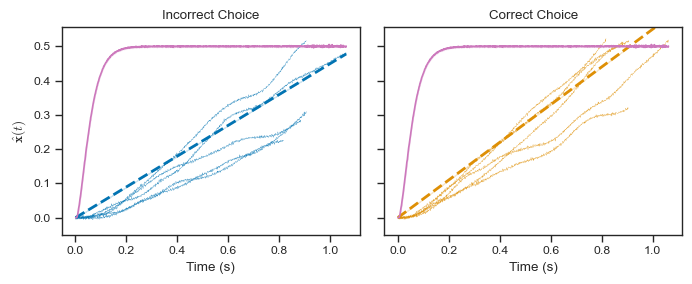

In [9]:
multiple_trial(coherence=0.1, trials=5, perception_seed=0)

In [10]:
def noisy_perception(coherence,
                   trials=3,
                   perception_seed=0,
                   network_seed=0,
                   dt=0.001,
                   dt_samples=[0, 0.02, 0.04],
                   ramp=1,
                   threshold=0.5,
                   relative=0,
                   name="noisy_perception"):

    fig, axes = plt.subplots(nrows=len(dt_samples), ncols=2, sharex=True, sharey=True, figsize=((7.08, 2*len(dt_samples))))
    dfs = []

    for dt_sample in dt_samples:
        inputs = Inputs_TwoDots(dt_sample=dt_sample, seed=perception_seed)
        inputs.create(coherence=coherence)

        for trial in range(trials):
            print(f"trial {trial}, dt_sample {dt_sample}")
            net = build_network(inputs, seed=network_seed+trial, ramp=ramp, threshold=threshold, relative=relative)
            sim = nengo.Simulator(net, progress_bar=False)
            choice = None
            while choice==None:
                sim.run(dt)
                if sim.data[net.pAction][-1,0] > 0:
                    choice = "L"
                    RT = sim.trange()[-1]
                elif sim.data[net.pAction][-1,1] > 0:
                    choice = "R"
                    RT = sim.trange()[-1]
                elif sim.trange()[-1] > 5:
                    choice = "L" if sim.data[net.pValue][-1,0] > sim.data[net.pValue][-1,1] else "R"
                    RT = sim.trange()[-1]
            correct = True if choice==inputs.correct else False
            dfs.append(pd.DataFrame({
                'coherence': coherence*np.ones_like(sim.trange()),
                'trial': trial*np.ones_like(sim.trange()),
                'dt_sample': dt_sample*np.ones_like(sim.trange()),
                'time':sim.trange(),
                'ideal L':sim.trange()/dt * net.inputs.L * net.ramp * dt,
                'ideal R':sim.trange()/dt * net.inputs.R * net.ramp * dt,
                'evidence L':sim.data[net.pAccumulator][:,0].ravel(),
                'evidence R':sim.data[net.pAccumulator][:,1].ravel(),
                'value L':sim.data[net.pValue][:,0].ravel(),
                'value R':sim.data[net.pValue][:,1].ravel(),
                'gate':sim.data[net.pGate].ravel(),
                'correct':correct*1.0*np.ones_like(sim.trange()),
                'RT':RT*1.0*np.ones_like(sim.trange()),
            }))

    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")
    
    ymax = data['gate'].max() + 0.05
    row = 0
    for dt_sample in dt_samples:
        subdata = data.query("dt_sample==@dt_sample")
        sns.lineplot(data=subdata, x='time', y='value L', units='trial', estimator=None, lw=0.2, color=palette[0], ax=axes[row][0])
        sns.lineplot(data=subdata, x='time', y='ideal L', linestyle="--", lw=2, color=palette[0], ax=axes[row][0])
        sns.lineplot(data=subdata, x='time', y='value R', units='trial', estimator=None, lw=0.2, color=palette[1], ax=axes[row][1])
        sns.lineplot(data=subdata, x='time', y='ideal R', linestyle="--", lw=2, color=palette[1], ax=axes[row][1])
        sns.lineplot(data=subdata, x='time', y='gate', color=palette[4], ax=axes[row][0])
        sns.lineplot(data=subdata, x='time', y='gate', color=palette[4], ax=axes[row][1])
        if inputs.correct=="L" and row==0:
            axes[row][0].set(title="Correct Choice")
            axes[row][1].set(title="Incorrect Choice")
        if inputs.correct=="R" and row==0:
            axes[row][0].set(title="Incorrect Choice")
            axes[row][1].set(title="Correct Choice")
        axes[row][0].set(ylabel=f"dt_sample={dt_sample}")
        row += 1
    axes[0][0].set(ylabel="Perfect Perception\n(view coherence)", ylim=((-0.05, ymax)))
    axes[1][0].set(ylabel="Noisy Sampling\n(high frequency)", ylim=((-0.05, ymax)))
    axes[2][0].set(ylabel="Noisy Sampling\n(low frequency)", ylim=((-0.05, ymax)))
    axes[2][0].set(xlabel="Time (s)")
    axes[2][1].set(xlabel="Time (s)")
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

trial 0, dt_sample 0
trial 1, dt_sample 0
trial 2, dt_sample 0
trial 3, dt_sample 0
trial 4, dt_sample 0
trial 5, dt_sample 0
trial 6, dt_sample 0
trial 7, dt_sample 0
trial 8, dt_sample 0
trial 9, dt_sample 0
trial 0, dt_sample 0.005
trial 1, dt_sample 0.005
trial 2, dt_sample 0.005
trial 3, dt_sample 0.005
trial 4, dt_sample 0.005
trial 5, dt_sample 0.005
trial 6, dt_sample 0.005
trial 7, dt_sample 0.005
trial 8, dt_sample 0.005
trial 9, dt_sample 0.005
trial 0, dt_sample 0.02
trial 1, dt_sample 0.02
trial 2, dt_sample 0.02
trial 3, dt_sample 0.02
trial 4, dt_sample 0.02
trial 5, dt_sample 0.02
trial 6, dt_sample 0.02
trial 7, dt_sample 0.02
trial 8, dt_sample 0.02
trial 9, dt_sample 0.02


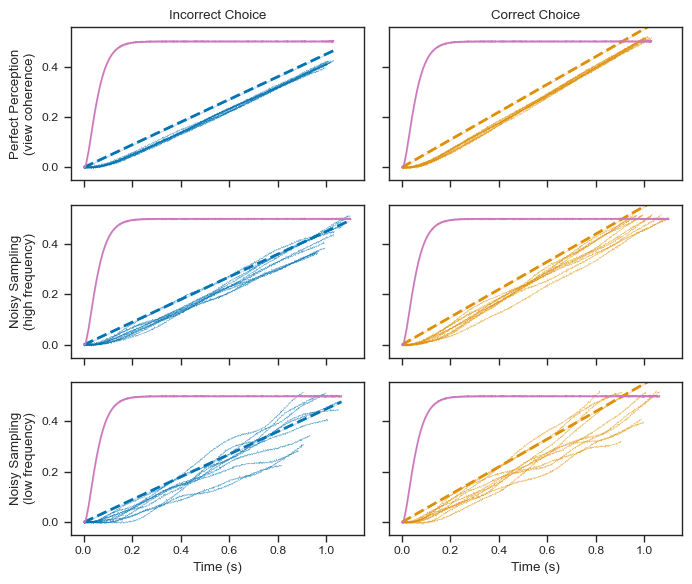

In [11]:
noisy_perception(dt_samples=[0,0.005,0.02], coherence=0.1, trials=10, perception_seed=0)

In [12]:
def absolute_vs_relative(coherence,
                   trials=1,
                   perception_seed=0,
                   network_seed=0,
                   dt=0.001,
                   dt_sample=0.02,
                   ramp=1,
                   threshold=0.5,
                   relative=1,
                   name="absolute_vs_relative"):

    dfs = []
    inputs = Inputs_TwoDots(dt_sample=dt_sample, seed=perception_seed)
    inputs.create(coherence=coherence)
    for trial in range(trials):
        net = build_network(inputs, seed=network_seed+trial, ramp=ramp, threshold=threshold, relative=relative)
        sim = nengo.Simulator(net, progress_bar=False)
        choice = None
        while choice==None:
            sim.run(dt)
            if sim.data[net.pAction][-1,0] > 0:
                choice = "L"
                RT = sim.trange()[-1]
            elif sim.data[net.pAction][-1,1] > 0:
                choice = "R"
                RT = sim.trange()[-1]
            elif sim.trange()[-1] > 5:
                choice = "L" if sim.data[net.pValue][-1,0] > sim.data[net.pValue][-1,1] else "R"
                RT = sim.trange()[-1]
        correct = True if choice==inputs.correct else False
        dfs.append(pd.DataFrame({
            'coherence': coherence*np.ones_like(sim.trange()),
            'trial': trial*np.ones_like(sim.trange()),
            'time':sim.trange(),
            'ideal L':sim.trange()/dt * net.inputs.L * net.ramp * dt,
            'ideal R':sim.trange()/dt * net.inputs.R * net.ramp * dt,
            'ideal delta':sim.trange()/dt * np.abs(net.inputs.L-net.inputs.R) * net.ramp * dt,
            'evidence L':sim.data[net.pAccumulator][:,0].ravel(),
            'evidence R':sim.data[net.pAccumulator][:,1].ravel(),
            'value L':sim.data[net.pValue][:,0].ravel(),
            'value R':sim.data[net.pValue][:,1].ravel(),
            'gate':sim.data[net.pGate].ravel(),
            'correct':correct*1.0*np.ones_like(sim.trange()),
            'RT':RT*1.0*np.ones_like(sim.trange()),
        }))

    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=((7.08, 3)))
    sns.lineplot(data=data, x='time', y='evidence L', color=palette[0], ax=axes[0], label="raw evidence L")
    sns.lineplot(data=data, x='time', y='evidence R', color=palette[1], ax=axes[0], label="raw evidence R")
    sns.lineplot(data=data, x='time', y='gate', color=palette[4], ax=axes[0], label="absolute threshold")
    sns.lineplot(data=data, x='time', y='value L', color=palette[0], ax=axes[1], label="relative value L")
    sns.lineplot(data=data, x='time', y='value R', color=palette[1], ax=axes[1], label="relative value R")
    sns.lineplot(data=data, x='time', y='gate', color=palette[4], ax=axes[1], label="relative threshold")
    axes[0].set(title="Absolute Value")
    axes[1].set(title="Relative Value")
    axes[0].set(xlabel="Time (s)", ylabel=r"$\hat{\mathbf{x}}(t)$")
    axes[1].set(xlabel="Time (s)", ylabel=r"$\hat{\mathbf{x}}(t)$")
    axes[0].legend()
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

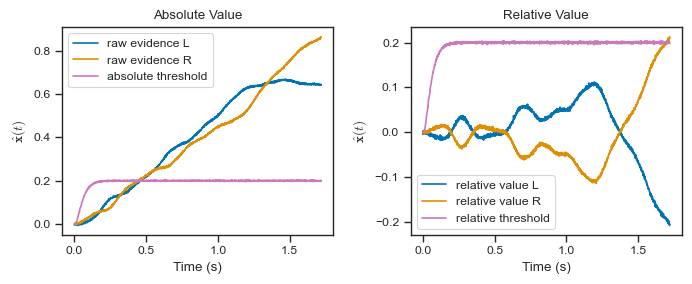

In [13]:
absolute_vs_relative(coherence=0.1, threshold=0.2, perception_seed=34)

In [14]:
def vary_ramp_threshold(coherence,
                   trials=3,
                   perception_seed=0,
                   network_seed=0,
                   dt=0.001,
                   dt_sample=0.02,
                   ramps=[0.5, 1],
                   thresholds=[0.3, 0.5],
                   relative=0,
                   name="vary_ramp_threshold"):

    dfs = []

    for ramp in ramps:
        for threshold in thresholds:
            inputs = Inputs_TwoDots(dt_sample=dt_sample, seed=perception_seed)
            inputs.create(coherence=coherence)
            for trial in range(trials):
                print(f"trial {trial}, ramp {ramp}, threshold {threshold}")
                net = build_network(inputs, seed=network_seed+trial, ramp=ramp, threshold=threshold, relative=relative)
                sim = nengo.Simulator(net, progress_bar=False)
                choice = None
                while choice==None:
                    sim.run(dt)
                    if sim.data[net.pAction][-1,0] > 0:
                        choice = "L"
                        RT = sim.trange()[-1]
                    elif sim.data[net.pAction][-1,1] > 0:
                        choice = "R"
                        RT = sim.trange()[-1]
                    elif sim.trange()[-1] > 5:
                        choice = "L" if sim.data[net.pValue][-1,0] > sim.data[net.pValue][-1,1] else "R"
                        RT = sim.trange()[-1]
                correct = True if choice==inputs.correct else False
                dfs.append(pd.DataFrame({
                    'coherence': coherence*np.ones_like(sim.trange()),
                    'trial': trial*np.ones_like(sim.trange()),
                    'ramp': ramp*np.ones_like(sim.trange()),
                    'threshold': threshold*np.ones_like(sim.trange()),
                    'time':sim.trange(),
                    'ideal L':sim.trange()/dt * net.inputs.L * net.ramp * dt,
                    'ideal R':sim.trange()/dt * net.inputs.R * net.ramp * dt,
                    'evidence L':sim.data[net.pAccumulator][:,0].ravel(),
                    'evidence R':sim.data[net.pAccumulator][:,1].ravel(),
                    'value L':sim.data[net.pValue][:,0].ravel(),
                    'value R':sim.data[net.pValue][:,1].ravel(),
                    'gate':sim.data[net.pGate].ravel(),
                    'correct':correct*1.0*np.ones_like(sim.trange()),
                    'RT':RT*1.0*np.ones_like(sim.trange()),
                }))

    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")
    
    fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=((7.08, 4)))
    for r in range(len(ramps)):
        for t in range(len(thresholds)):
            ramp, threshold = ramps[r], thresholds[t]
            subdata = data.query("ramp==@ramp & threshold==@threshold")
            sns.lineplot(data=subdata, x='time', y='value L', units='trial', estimator=None, lw=0.2, color=palette[0], ax=axes[r][t])
            sns.lineplot(data=subdata, x='time', y='value R', units='trial', estimator=None, lw=0.2, color=palette[1], ax=axes[r][t])
            sns.lineplot(data=subdata, x='time', y='gate', units='trial', estimator=None, color=palette[4], ax=axes[r][t])
            axes[r][t].set(title=f"ramp {ramp}, threshold {threshold}")
#     axes[0][0].set(ylabel="Perfect Perception\n(view coherence)", ylim=((-0.05, ymax)))
#     axes[1][0].set(ylabel="Noisy Sampling\n(high frequency)", ylim=((-0.05, ymax)))
#     axes[2][0].set(ylabel="Noisy Sampling\n(low frequency)", ylim=((-0.05, ymax)))
    axes[0][0].set(ylabel=r"$\hat{\mathbf{x}}(t)$")
    axes[1][0].set(xlabel="Time (s)")
    axes[1][1].set(ylabel=r"$\hat{\mathbf{x}}(t)$", xlabel="Time (s)")
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

trial 0, ramp 0.5, threshold 0.3
trial 1, ramp 0.5, threshold 0.3
trial 2, ramp 0.5, threshold 0.3
trial 3, ramp 0.5, threshold 0.3
trial 4, ramp 0.5, threshold 0.3
trial 5, ramp 0.5, threshold 0.3
trial 6, ramp 0.5, threshold 0.3
trial 7, ramp 0.5, threshold 0.3
trial 8, ramp 0.5, threshold 0.3
trial 9, ramp 0.5, threshold 0.3
trial 0, ramp 0.5, threshold 0.5
trial 1, ramp 0.5, threshold 0.5
trial 2, ramp 0.5, threshold 0.5
trial 3, ramp 0.5, threshold 0.5
trial 4, ramp 0.5, threshold 0.5
trial 5, ramp 0.5, threshold 0.5
trial 6, ramp 0.5, threshold 0.5
trial 7, ramp 0.5, threshold 0.5
trial 8, ramp 0.5, threshold 0.5
trial 9, ramp 0.5, threshold 0.5
trial 0, ramp 1, threshold 0.3
trial 1, ramp 1, threshold 0.3
trial 2, ramp 1, threshold 0.3
trial 3, ramp 1, threshold 0.3
trial 4, ramp 1, threshold 0.3
trial 5, ramp 1, threshold 0.3
trial 6, ramp 1, threshold 0.3
trial 7, ramp 1, threshold 0.3
trial 8, ramp 1, threshold 0.3
trial 9, ramp 1, threshold 0.3
trial 0, ramp 1, threshold 0.5

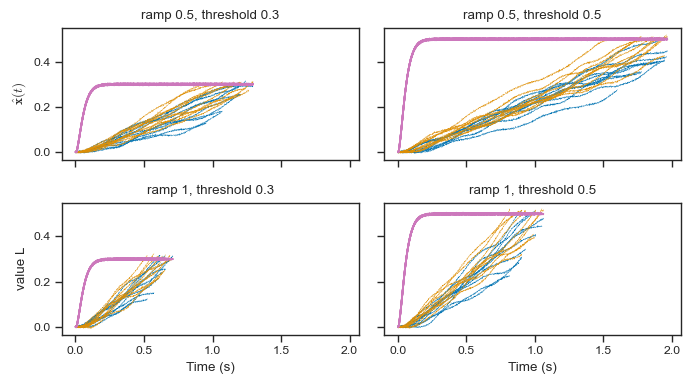

In [15]:
vary_ramp_threshold(coherence=0.1, trials=10)

In [16]:
def scan_coherence(coherences=np.geomspace(0.008, 0.512, 7),
                   trials_per_coherence=3,
                   perception_seed=0,
                   network_seed=0,
                   dt=0.001,
                   dt_sample=0.01,
                   ramp=1,
                   threshold=0.5,
                   relative=0,
                   name="revised_scan_default"):
    
    inputs = Inputs_TwoDots(dt_sample=dt_sample, seed=perception_seed)
    inputs.create(coherence=coherences[0])
    net = build_network(inputs, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative)

    columns = ('trial', 'coherence', 'RT', 'correct')
    dfs = []
    for coherence in coherences:
        for trial in range(trials_per_coherence):
            print(f"trial {trial}, coherence {coherence}")
            inputs.create(coherence=coherence)
            sim = nengo.Simulator(net, progress_bar=False)
            choice = None
            while choice==None:
                sim.run(dt)
                if sim.data[net.pAction][-1,0] > 0:
                    choice = "L"
                    RT = sim.trange()[-1]
                elif sim.data[net.pAction][-1,1] > 0:
                    choice = "R"
                    RT = sim.trange()[-1]
                elif sim.trange()[-1] > 5:
                    choice = "L" if sim.data[net.pValue][-1,0] > sim.data[net.pValue][-1,1] else "R"
                    RT = sim.trange()[-1]
            correct = True if choice==inputs.correct else False
#             print(coherence, RT, correct)
            dfs.append(pd.DataFrame([[trial, coherence, RT, correct]], columns=columns))
    data = pd.concat(dfs, ignore_index=True)
    data.to_pickle(f"data/{name}.pkl")
    
    fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=((7.08, 4)))
    sns.lineplot(data=data, x='coherence', y='RT', ax=axes[0])
    sns.lineplot(data=data, x='coherence', y='correct', ax=axes[1])
    plt.xscale('log')
    plt.tight_layout()

trial 0, coherence 0.01
trial 1, coherence 0.01
trial 2, coherence 0.01
trial 3, coherence 0.01
trial 4, coherence 0.01
trial 5, coherence 0.01
trial 6, coherence 0.01
trial 7, coherence 0.01
trial 8, coherence 0.01
trial 9, coherence 0.01
trial 10, coherence 0.01
trial 11, coherence 0.01
trial 12, coherence 0.01
trial 13, coherence 0.01
trial 14, coherence 0.01
trial 15, coherence 0.01
trial 16, coherence 0.01
trial 17, coherence 0.01
trial 18, coherence 0.01
trial 19, coherence 0.01
trial 20, coherence 0.01
trial 21, coherence 0.01
trial 22, coherence 0.01
trial 23, coherence 0.01
trial 24, coherence 0.01
trial 25, coherence 0.01
trial 26, coherence 0.01
trial 27, coherence 0.01
trial 28, coherence 0.01
trial 29, coherence 0.01
trial 30, coherence 0.01
trial 31, coherence 0.01
trial 32, coherence 0.01
trial 33, coherence 0.01
trial 34, coherence 0.01
trial 35, coherence 0.01
trial 36, coherence 0.01
trial 37, coherence 0.01
trial 38, coherence 0.01
trial 39, coherence 0.01
trial 40, 

trial 40, coherence 0.027825594022071243
trial 41, coherence 0.027825594022071243
trial 42, coherence 0.027825594022071243
trial 43, coherence 0.027825594022071243
trial 44, coherence 0.027825594022071243
trial 45, coherence 0.027825594022071243
trial 46, coherence 0.027825594022071243
trial 47, coherence 0.027825594022071243
trial 48, coherence 0.027825594022071243
trial 49, coherence 0.027825594022071243
trial 50, coherence 0.027825594022071243
trial 51, coherence 0.027825594022071243
trial 52, coherence 0.027825594022071243
trial 53, coherence 0.027825594022071243
trial 54, coherence 0.027825594022071243
trial 55, coherence 0.027825594022071243
trial 56, coherence 0.027825594022071243
trial 57, coherence 0.027825594022071243
trial 58, coherence 0.027825594022071243
trial 59, coherence 0.027825594022071243
trial 60, coherence 0.027825594022071243
trial 61, coherence 0.027825594022071243
trial 62, coherence 0.027825594022071243
trial 63, coherence 0.027825594022071243
trial 64, cohere

trial 43, coherence 0.0774263682681127
trial 44, coherence 0.0774263682681127
trial 45, coherence 0.0774263682681127
trial 46, coherence 0.0774263682681127
trial 47, coherence 0.0774263682681127
trial 48, coherence 0.0774263682681127
trial 49, coherence 0.0774263682681127
trial 50, coherence 0.0774263682681127
trial 51, coherence 0.0774263682681127
trial 52, coherence 0.0774263682681127
trial 53, coherence 0.0774263682681127
trial 54, coherence 0.0774263682681127
trial 55, coherence 0.0774263682681127
trial 56, coherence 0.0774263682681127
trial 57, coherence 0.0774263682681127
trial 58, coherence 0.0774263682681127
trial 59, coherence 0.0774263682681127
trial 60, coherence 0.0774263682681127
trial 61, coherence 0.0774263682681127
trial 62, coherence 0.0774263682681127
trial 63, coherence 0.0774263682681127
trial 64, coherence 0.0774263682681127
trial 65, coherence 0.0774263682681127
trial 66, coherence 0.0774263682681127
trial 67, coherence 0.0774263682681127
trial 68, coherence 0.077

trial 53, coherence 0.21544346900318834
trial 54, coherence 0.21544346900318834
trial 55, coherence 0.21544346900318834
trial 56, coherence 0.21544346900318834
trial 57, coherence 0.21544346900318834
trial 58, coherence 0.21544346900318834
trial 59, coherence 0.21544346900318834
trial 60, coherence 0.21544346900318834
trial 61, coherence 0.21544346900318834
trial 62, coherence 0.21544346900318834
trial 63, coherence 0.21544346900318834
trial 64, coherence 0.21544346900318834
trial 65, coherence 0.21544346900318834
trial 66, coherence 0.21544346900318834
trial 67, coherence 0.21544346900318834
trial 68, coherence 0.21544346900318834
trial 69, coherence 0.21544346900318834
trial 70, coherence 0.21544346900318834
trial 71, coherence 0.21544346900318834
trial 72, coherence 0.21544346900318834
trial 73, coherence 0.21544346900318834
trial 74, coherence 0.21544346900318834
trial 75, coherence 0.21544346900318834
trial 76, coherence 0.21544346900318834
trial 77, coherence 0.21544346900318834


trial 63, coherence 0.5994842503189409
trial 64, coherence 0.5994842503189409
trial 65, coherence 0.5994842503189409
trial 66, coherence 0.5994842503189409
trial 67, coherence 0.5994842503189409
trial 68, coherence 0.5994842503189409
trial 69, coherence 0.5994842503189409
trial 70, coherence 0.5994842503189409
trial 71, coherence 0.5994842503189409
trial 72, coherence 0.5994842503189409
trial 73, coherence 0.5994842503189409
trial 74, coherence 0.5994842503189409
trial 75, coherence 0.5994842503189409
trial 76, coherence 0.5994842503189409
trial 77, coherence 0.5994842503189409
trial 78, coherence 0.5994842503189409
trial 79, coherence 0.5994842503189409
trial 80, coherence 0.5994842503189409
trial 81, coherence 0.5994842503189409
trial 82, coherence 0.5994842503189409
trial 83, coherence 0.5994842503189409
trial 84, coherence 0.5994842503189409
trial 85, coherence 0.5994842503189409
trial 86, coherence 0.5994842503189409
trial 87, coherence 0.5994842503189409
trial 88, coherence 0.599

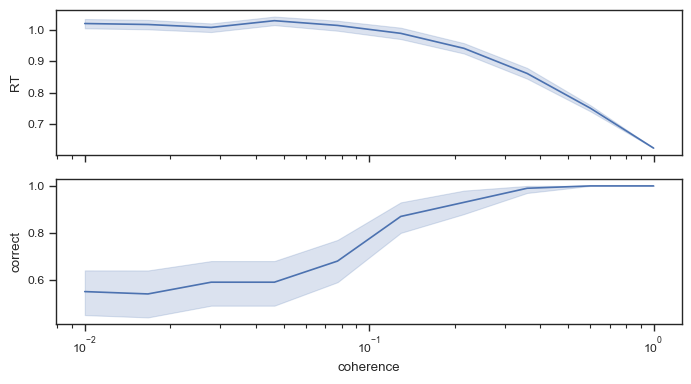

In [17]:
scan_coherence(coherences=np.geomspace(0.01, 1.0, 10), trials_per_coherence=100, dt_sample=0.02)

In [40]:
def scan_coherence_ramp_threshold(
        coherences=np.geomspace(0.01, 1.0, 5),
        ramps=[0.5, 1.0],
        thresholds=[0.3, 0.6],
        trials=3,
        perception_seed=0,
        dt=0.001,
        dt_sample=0.02,
        relative=0,
        load=False,
        errbar="se",
        RT_min=0.3,
        name="scan_coherence_ramp_threshold"):
    
    if not load:
        inputs = Inputs_TwoDots(dt_sample=dt_sample, seed=perception_seed)
        network_seed = 0
        columns = ('ramp', 'threshold', 'coherence', 'trial', 'RT', 'correct')
        dfs = []
        for ramp in ramps:
            for threshold in thresholds:
                for coherence in coherences:
                    for trial in range(trials):
                        print(f"trial {trial}, coherence {coherence}, ramp {ramp}, threshold {threshold}")
                        network_seed += 1
                        inputs.create(coherence=coherence)
                        net = build_network(inputs, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative)
                        sim = nengo.Simulator(net, progress_bar=False)
                        choice = None
                        while choice==None:
                            sim.run(dt)
                            if sim.data[net.pAction][-1,0] > 0:
                                choice = "L"
                                RT = sim.trange()[-1]
                            elif sim.data[net.pAction][-1,1] > 0:
                                choice = "R"
                                RT = sim.trange()[-1]
                            elif sim.trange()[-1] > 5:
                                choice = "L" if sim.data[net.pValue][-1,0] > sim.data[net.pValue][-1,1] else "R"
                                RT = sim.trange()[-1]
                        correct = True if choice==inputs.correct else False
                        if RT > RT_min:
                            dfs.append(pd.DataFrame([[ramp, threshold, 100*coherence, trial, 1000*RT, 100*correct]], columns=columns))
        data = pd.concat(dfs, ignore_index=True)
        data.to_pickle(f"data/{name}.pkl")
    else:
        data = pd.read_pickle(f"data/{name}.pkl")

    fig, axes = plt.subplots(nrows=len(ramps), ncols=len(thresholds), sharex=True, sharey=True, figsize=((7.08, 2*len(ramps))))
    for r in range(len(ramps)):
        for t in range(len(thresholds)):
            ramp, threshold = ramps[r], thresholds[t]
            sns.lineplot(data=data.query("ramp==@ramp & threshold==@threshold"), x='coherence', y='RT', errorbar=errbar, ax=axes[r][t])
            axes[r][t].set(title=f"ramp {ramp}, threshold {threshold}")
    for r in range(len(ramps)):
        axes[r][0].set(ylabel="Response Times (ms)")
    for t in range(len(thresholds)):
        axes[len(ramps)-1][t].set(xlabel="Coherence (% motion strength)")
    plt.xscale('log')
    plt.tight_layout()
    fig.savefig(f"plots/{name}_RT.svg")
    fig.savefig(f"plots/{name}_RT.png", dpi=600)
    
    fig, axes = plt.subplots(nrows=len(ramps), ncols=len(thresholds), sharex=True, sharey=True, figsize=((7.08, 2*len(ramps))))
    for r in range(len(ramps)):
        for t in range(len(thresholds)):
            ramp, threshold = ramps[r], thresholds[t]
            sns.lineplot(data=data.query("ramp==@ramp & threshold==@threshold"), x='coherence', y='correct', errorbar=errbar, ax=axes[r][t])
            axes[r][t].set(title=f"ramp {ramp}, threshold {threshold}")
    for r in range(len(ramps)):
        axes[r][0].set(ylabel="Accuracy (%)")
    for t in range(len(thresholds)):
        axes[len(ramps)-1][t].set(xlabel="Coherence (% motion strength)")
    plt.xscale('log')
    plt.tight_layout()
    fig.savefig(f"plots/{name}_accuracy.svg")
    fig.savefig(f"plots/{name}_accuracy.png", dpi=600)

trial 0, coherence 0.01, ramp 0.5, threshold 0.3
trial 1, coherence 0.01, ramp 0.5, threshold 0.3
trial 2, coherence 0.01, ramp 0.5, threshold 0.3
trial 3, coherence 0.01, ramp 0.5, threshold 0.3
trial 4, coherence 0.01, ramp 0.5, threshold 0.3
trial 5, coherence 0.01, ramp 0.5, threshold 0.3
trial 6, coherence 0.01, ramp 0.5, threshold 0.3
trial 7, coherence 0.01, ramp 0.5, threshold 0.3
trial 8, coherence 0.01, ramp 0.5, threshold 0.3
trial 9, coherence 0.01, ramp 0.5, threshold 0.3
trial 10, coherence 0.01, ramp 0.5, threshold 0.3
trial 11, coherence 0.01, ramp 0.5, threshold 0.3
trial 12, coherence 0.01, ramp 0.5, threshold 0.3
trial 13, coherence 0.01, ramp 0.5, threshold 0.3
trial 14, coherence 0.01, ramp 0.5, threshold 0.3
trial 15, coherence 0.01, ramp 0.5, threshold 0.3
trial 16, coherence 0.01, ramp 0.5, threshold 0.3
trial 17, coherence 0.01, ramp 0.5, threshold 0.3
trial 18, coherence 0.01, ramp 0.5, threshold 0.3
trial 19, coherence 0.01, ramp 0.5, threshold 0.3
trial 20, 

trial 49, coherence 0.016681005372000592, ramp 0.5, threshold 0.3
trial 50, coherence 0.016681005372000592, ramp 0.5, threshold 0.3
trial 51, coherence 0.016681005372000592, ramp 0.5, threshold 0.3
trial 52, coherence 0.016681005372000592, ramp 0.5, threshold 0.3
trial 53, coherence 0.016681005372000592, ramp 0.5, threshold 0.3
trial 54, coherence 0.016681005372000592, ramp 0.5, threshold 0.3
trial 55, coherence 0.016681005372000592, ramp 0.5, threshold 0.3
trial 56, coherence 0.016681005372000592, ramp 0.5, threshold 0.3
trial 57, coherence 0.016681005372000592, ramp 0.5, threshold 0.3
trial 58, coherence 0.016681005372000592, ramp 0.5, threshold 0.3
trial 59, coherence 0.016681005372000592, ramp 0.5, threshold 0.3
trial 60, coherence 0.016681005372000592, ramp 0.5, threshold 0.3
trial 61, coherence 0.016681005372000592, ramp 0.5, threshold 0.3
trial 62, coherence 0.016681005372000592, ramp 0.5, threshold 0.3
trial 63, coherence 0.016681005372000592, ramp 0.5, threshold 0.3
trial 64, 

trial 74, coherence 0.027825594022071243, ramp 0.5, threshold 0.3
trial 75, coherence 0.027825594022071243, ramp 0.5, threshold 0.3
trial 76, coherence 0.027825594022071243, ramp 0.5, threshold 0.3
trial 77, coherence 0.027825594022071243, ramp 0.5, threshold 0.3
trial 78, coherence 0.027825594022071243, ramp 0.5, threshold 0.3
trial 79, coherence 0.027825594022071243, ramp 0.5, threshold 0.3
trial 80, coherence 0.027825594022071243, ramp 0.5, threshold 0.3
trial 81, coherence 0.027825594022071243, ramp 0.5, threshold 0.3
trial 82, coherence 0.027825594022071243, ramp 0.5, threshold 0.3
trial 83, coherence 0.027825594022071243, ramp 0.5, threshold 0.3
trial 84, coherence 0.027825594022071243, ramp 0.5, threshold 0.3
trial 85, coherence 0.027825594022071243, ramp 0.5, threshold 0.3
trial 86, coherence 0.027825594022071243, ramp 0.5, threshold 0.3
trial 87, coherence 0.027825594022071243, ramp 0.5, threshold 0.3
trial 88, coherence 0.027825594022071243, ramp 0.5, threshold 0.3
trial 89, 

trial 99, coherence 0.046415888336127774, ramp 0.5, threshold 0.3
trial 0, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 1, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 2, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 3, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 4, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 5, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 6, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 7, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 8, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 9, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 10, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 11, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 12, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 13, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 14, coherence 0.0774263682681127, ramp 0.5

trial 28, coherence 0.1291549665014884, ramp 0.5, threshold 0.3
trial 29, coherence 0.1291549665014884, ramp 0.5, threshold 0.3
trial 30, coherence 0.1291549665014884, ramp 0.5, threshold 0.3
trial 31, coherence 0.1291549665014884, ramp 0.5, threshold 0.3
trial 32, coherence 0.1291549665014884, ramp 0.5, threshold 0.3
trial 33, coherence 0.1291549665014884, ramp 0.5, threshold 0.3
trial 34, coherence 0.1291549665014884, ramp 0.5, threshold 0.3
trial 35, coherence 0.1291549665014884, ramp 0.5, threshold 0.3
trial 36, coherence 0.1291549665014884, ramp 0.5, threshold 0.3
trial 37, coherence 0.1291549665014884, ramp 0.5, threshold 0.3
trial 38, coherence 0.1291549665014884, ramp 0.5, threshold 0.3
trial 39, coherence 0.1291549665014884, ramp 0.5, threshold 0.3
trial 40, coherence 0.1291549665014884, ramp 0.5, threshold 0.3
trial 41, coherence 0.1291549665014884, ramp 0.5, threshold 0.3
trial 42, coherence 0.1291549665014884, ramp 0.5, threshold 0.3
trial 43, coherence 0.1291549665014884, 

trial 56, coherence 0.21544346900318834, ramp 0.5, threshold 0.3
trial 57, coherence 0.21544346900318834, ramp 0.5, threshold 0.3
trial 58, coherence 0.21544346900318834, ramp 0.5, threshold 0.3
trial 59, coherence 0.21544346900318834, ramp 0.5, threshold 0.3
trial 60, coherence 0.21544346900318834, ramp 0.5, threshold 0.3
trial 61, coherence 0.21544346900318834, ramp 0.5, threshold 0.3
trial 62, coherence 0.21544346900318834, ramp 0.5, threshold 0.3
trial 63, coherence 0.21544346900318834, ramp 0.5, threshold 0.3
trial 64, coherence 0.21544346900318834, ramp 0.5, threshold 0.3
trial 65, coherence 0.21544346900318834, ramp 0.5, threshold 0.3
trial 66, coherence 0.21544346900318834, ramp 0.5, threshold 0.3
trial 67, coherence 0.21544346900318834, ramp 0.5, threshold 0.3
trial 68, coherence 0.21544346900318834, ramp 0.5, threshold 0.3
trial 69, coherence 0.21544346900318834, ramp 0.5, threshold 0.3
trial 70, coherence 0.21544346900318834, ramp 0.5, threshold 0.3
trial 71, coherence 0.215

trial 84, coherence 0.3593813663804626, ramp 0.5, threshold 0.3
trial 85, coherence 0.3593813663804626, ramp 0.5, threshold 0.3
trial 86, coherence 0.3593813663804626, ramp 0.5, threshold 0.3
trial 87, coherence 0.3593813663804626, ramp 0.5, threshold 0.3
trial 88, coherence 0.3593813663804626, ramp 0.5, threshold 0.3
trial 89, coherence 0.3593813663804626, ramp 0.5, threshold 0.3
trial 90, coherence 0.3593813663804626, ramp 0.5, threshold 0.3
trial 91, coherence 0.3593813663804626, ramp 0.5, threshold 0.3
trial 92, coherence 0.3593813663804626, ramp 0.5, threshold 0.3
trial 93, coherence 0.3593813663804626, ramp 0.5, threshold 0.3
trial 94, coherence 0.3593813663804626, ramp 0.5, threshold 0.3
trial 95, coherence 0.3593813663804626, ramp 0.5, threshold 0.3
trial 96, coherence 0.3593813663804626, ramp 0.5, threshold 0.3
trial 97, coherence 0.3593813663804626, ramp 0.5, threshold 0.3
trial 98, coherence 0.3593813663804626, ramp 0.5, threshold 0.3
trial 99, coherence 0.3593813663804626, 

trial 17, coherence 1.0, ramp 0.5, threshold 0.3
trial 18, coherence 1.0, ramp 0.5, threshold 0.3
trial 19, coherence 1.0, ramp 0.5, threshold 0.3
trial 20, coherence 1.0, ramp 0.5, threshold 0.3
trial 21, coherence 1.0, ramp 0.5, threshold 0.3
trial 22, coherence 1.0, ramp 0.5, threshold 0.3
trial 23, coherence 1.0, ramp 0.5, threshold 0.3
trial 24, coherence 1.0, ramp 0.5, threshold 0.3
trial 25, coherence 1.0, ramp 0.5, threshold 0.3
trial 26, coherence 1.0, ramp 0.5, threshold 0.3
trial 27, coherence 1.0, ramp 0.5, threshold 0.3
trial 28, coherence 1.0, ramp 0.5, threshold 0.3
trial 29, coherence 1.0, ramp 0.5, threshold 0.3
trial 30, coherence 1.0, ramp 0.5, threshold 0.3
trial 31, coherence 1.0, ramp 0.5, threshold 0.3
trial 32, coherence 1.0, ramp 0.5, threshold 0.3
trial 33, coherence 1.0, ramp 0.5, threshold 0.3
trial 34, coherence 1.0, ramp 0.5, threshold 0.3
trial 35, coherence 1.0, ramp 0.5, threshold 0.3
trial 36, coherence 1.0, ramp 0.5, threshold 0.3
trial 37, coherence 

trial 83, coherence 0.01, ramp 0.5, threshold 0.5
trial 84, coherence 0.01, ramp 0.5, threshold 0.5
trial 85, coherence 0.01, ramp 0.5, threshold 0.5
trial 86, coherence 0.01, ramp 0.5, threshold 0.5
trial 87, coherence 0.01, ramp 0.5, threshold 0.5
trial 88, coherence 0.01, ramp 0.5, threshold 0.5
trial 89, coherence 0.01, ramp 0.5, threshold 0.5
trial 90, coherence 0.01, ramp 0.5, threshold 0.5
trial 91, coherence 0.01, ramp 0.5, threshold 0.5
trial 92, coherence 0.01, ramp 0.5, threshold 0.5
trial 93, coherence 0.01, ramp 0.5, threshold 0.5
trial 94, coherence 0.01, ramp 0.5, threshold 0.5
trial 95, coherence 0.01, ramp 0.5, threshold 0.5
trial 96, coherence 0.01, ramp 0.5, threshold 0.5
trial 97, coherence 0.01, ramp 0.5, threshold 0.5
trial 98, coherence 0.01, ramp 0.5, threshold 0.5
trial 99, coherence 0.01, ramp 0.5, threshold 0.5
trial 0, coherence 0.016681005372000592, ramp 0.5, threshold 0.5
trial 1, coherence 0.016681005372000592, ramp 0.5, threshold 0.5
trial 2, coherence 0

trial 12, coherence 0.027825594022071243, ramp 0.5, threshold 0.5
trial 13, coherence 0.027825594022071243, ramp 0.5, threshold 0.5
trial 14, coherence 0.027825594022071243, ramp 0.5, threshold 0.5
trial 15, coherence 0.027825594022071243, ramp 0.5, threshold 0.5
trial 16, coherence 0.027825594022071243, ramp 0.5, threshold 0.5
trial 17, coherence 0.027825594022071243, ramp 0.5, threshold 0.5
trial 18, coherence 0.027825594022071243, ramp 0.5, threshold 0.5
trial 19, coherence 0.027825594022071243, ramp 0.5, threshold 0.5
trial 20, coherence 0.027825594022071243, ramp 0.5, threshold 0.5
trial 21, coherence 0.027825594022071243, ramp 0.5, threshold 0.5
trial 22, coherence 0.027825594022071243, ramp 0.5, threshold 0.5
trial 23, coherence 0.027825594022071243, ramp 0.5, threshold 0.5
trial 24, coherence 0.027825594022071243, ramp 0.5, threshold 0.5
trial 25, coherence 0.027825594022071243, ramp 0.5, threshold 0.5
trial 26, coherence 0.027825594022071243, ramp 0.5, threshold 0.5
trial 27, 

trial 37, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 38, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 39, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 40, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 41, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 42, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 43, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 44, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 45, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 46, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 47, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 48, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 49, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 50, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 51, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 52, 

trial 64, coherence 0.0774263682681127, ramp 0.5, threshold 0.5
trial 65, coherence 0.0774263682681127, ramp 0.5, threshold 0.5
trial 66, coherence 0.0774263682681127, ramp 0.5, threshold 0.5
trial 67, coherence 0.0774263682681127, ramp 0.5, threshold 0.5
trial 68, coherence 0.0774263682681127, ramp 0.5, threshold 0.5
trial 69, coherence 0.0774263682681127, ramp 0.5, threshold 0.5
trial 70, coherence 0.0774263682681127, ramp 0.5, threshold 0.5
trial 71, coherence 0.0774263682681127, ramp 0.5, threshold 0.5
trial 72, coherence 0.0774263682681127, ramp 0.5, threshold 0.5
trial 73, coherence 0.0774263682681127, ramp 0.5, threshold 0.5
trial 74, coherence 0.0774263682681127, ramp 0.5, threshold 0.5
trial 75, coherence 0.0774263682681127, ramp 0.5, threshold 0.5
trial 76, coherence 0.0774263682681127, ramp 0.5, threshold 0.5
trial 77, coherence 0.0774263682681127, ramp 0.5, threshold 0.5
trial 78, coherence 0.0774263682681127, ramp 0.5, threshold 0.5
trial 79, coherence 0.0774263682681127, 

trial 93, coherence 0.1291549665014884, ramp 0.5, threshold 0.5
trial 94, coherence 0.1291549665014884, ramp 0.5, threshold 0.5
trial 95, coherence 0.1291549665014884, ramp 0.5, threshold 0.5
trial 96, coherence 0.1291549665014884, ramp 0.5, threshold 0.5
trial 97, coherence 0.1291549665014884, ramp 0.5, threshold 0.5
trial 98, coherence 0.1291549665014884, ramp 0.5, threshold 0.5
trial 99, coherence 0.1291549665014884, ramp 0.5, threshold 0.5
trial 0, coherence 0.21544346900318834, ramp 0.5, threshold 0.5
trial 1, coherence 0.21544346900318834, ramp 0.5, threshold 0.5
trial 2, coherence 0.21544346900318834, ramp 0.5, threshold 0.5
trial 3, coherence 0.21544346900318834, ramp 0.5, threshold 0.5
trial 4, coherence 0.21544346900318834, ramp 0.5, threshold 0.5
trial 5, coherence 0.21544346900318834, ramp 0.5, threshold 0.5
trial 6, coherence 0.21544346900318834, ramp 0.5, threshold 0.5
trial 7, coherence 0.21544346900318834, ramp 0.5, threshold 0.5
trial 8, coherence 0.21544346900318834, 

trial 20, coherence 0.3593813663804626, ramp 0.5, threshold 0.5
trial 21, coherence 0.3593813663804626, ramp 0.5, threshold 0.5
trial 22, coherence 0.3593813663804626, ramp 0.5, threshold 0.5
trial 23, coherence 0.3593813663804626, ramp 0.5, threshold 0.5
trial 24, coherence 0.3593813663804626, ramp 0.5, threshold 0.5
trial 25, coherence 0.3593813663804626, ramp 0.5, threshold 0.5
trial 26, coherence 0.3593813663804626, ramp 0.5, threshold 0.5
trial 27, coherence 0.3593813663804626, ramp 0.5, threshold 0.5
trial 28, coherence 0.3593813663804626, ramp 0.5, threshold 0.5
trial 29, coherence 0.3593813663804626, ramp 0.5, threshold 0.5
trial 30, coherence 0.3593813663804626, ramp 0.5, threshold 0.5
trial 31, coherence 0.3593813663804626, ramp 0.5, threshold 0.5
trial 32, coherence 0.3593813663804626, ramp 0.5, threshold 0.5
trial 33, coherence 0.3593813663804626, ramp 0.5, threshold 0.5
trial 34, coherence 0.3593813663804626, ramp 0.5, threshold 0.5
trial 35, coherence 0.3593813663804626, 

trial 49, coherence 0.5994842503189409, ramp 0.5, threshold 0.5
trial 50, coherence 0.5994842503189409, ramp 0.5, threshold 0.5
trial 51, coherence 0.5994842503189409, ramp 0.5, threshold 0.5
trial 52, coherence 0.5994842503189409, ramp 0.5, threshold 0.5
trial 53, coherence 0.5994842503189409, ramp 0.5, threshold 0.5
trial 54, coherence 0.5994842503189409, ramp 0.5, threshold 0.5
trial 55, coherence 0.5994842503189409, ramp 0.5, threshold 0.5
trial 56, coherence 0.5994842503189409, ramp 0.5, threshold 0.5
trial 57, coherence 0.5994842503189409, ramp 0.5, threshold 0.5
trial 58, coherence 0.5994842503189409, ramp 0.5, threshold 0.5
trial 59, coherence 0.5994842503189409, ramp 0.5, threshold 0.5
trial 60, coherence 0.5994842503189409, ramp 0.5, threshold 0.5
trial 61, coherence 0.5994842503189409, ramp 0.5, threshold 0.5
trial 62, coherence 0.5994842503189409, ramp 0.5, threshold 0.5
trial 63, coherence 0.5994842503189409, ramp 0.5, threshold 0.5
trial 64, coherence 0.5994842503189409, 

trial 1, coherence 0.01, ramp 1.0, threshold 0.3
trial 2, coherence 0.01, ramp 1.0, threshold 0.3
trial 3, coherence 0.01, ramp 1.0, threshold 0.3
trial 4, coherence 0.01, ramp 1.0, threshold 0.3
trial 5, coherence 0.01, ramp 1.0, threshold 0.3
trial 6, coherence 0.01, ramp 1.0, threshold 0.3
trial 7, coherence 0.01, ramp 1.0, threshold 0.3
trial 8, coherence 0.01, ramp 1.0, threshold 0.3
trial 9, coherence 0.01, ramp 1.0, threshold 0.3
trial 10, coherence 0.01, ramp 1.0, threshold 0.3
trial 11, coherence 0.01, ramp 1.0, threshold 0.3
trial 12, coherence 0.01, ramp 1.0, threshold 0.3
trial 13, coherence 0.01, ramp 1.0, threshold 0.3
trial 14, coherence 0.01, ramp 1.0, threshold 0.3
trial 15, coherence 0.01, ramp 1.0, threshold 0.3
trial 16, coherence 0.01, ramp 1.0, threshold 0.3
trial 17, coherence 0.01, ramp 1.0, threshold 0.3
trial 18, coherence 0.01, ramp 1.0, threshold 0.3
trial 19, coherence 0.01, ramp 1.0, threshold 0.3
trial 20, coherence 0.01, ramp 1.0, threshold 0.3
trial 21,

trial 50, coherence 0.016681005372000592, ramp 1.0, threshold 0.3
trial 51, coherence 0.016681005372000592, ramp 1.0, threshold 0.3
trial 52, coherence 0.016681005372000592, ramp 1.0, threshold 0.3
trial 53, coherence 0.016681005372000592, ramp 1.0, threshold 0.3
trial 54, coherence 0.016681005372000592, ramp 1.0, threshold 0.3
trial 55, coherence 0.016681005372000592, ramp 1.0, threshold 0.3
trial 56, coherence 0.016681005372000592, ramp 1.0, threshold 0.3
trial 57, coherence 0.016681005372000592, ramp 1.0, threshold 0.3
trial 58, coherence 0.016681005372000592, ramp 1.0, threshold 0.3
trial 59, coherence 0.016681005372000592, ramp 1.0, threshold 0.3
trial 60, coherence 0.016681005372000592, ramp 1.0, threshold 0.3
trial 61, coherence 0.016681005372000592, ramp 1.0, threshold 0.3
trial 62, coherence 0.016681005372000592, ramp 1.0, threshold 0.3
trial 63, coherence 0.016681005372000592, ramp 1.0, threshold 0.3
trial 64, coherence 0.016681005372000592, ramp 1.0, threshold 0.3
trial 65, 

trial 75, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 76, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 77, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 78, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 79, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 80, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 81, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 82, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 83, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 84, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 85, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 86, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 87, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 88, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 89, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 90, 

trial 0, coherence 0.0774263682681127, ramp 1.0, threshold 0.3
trial 1, coherence 0.0774263682681127, ramp 1.0, threshold 0.3
trial 2, coherence 0.0774263682681127, ramp 1.0, threshold 0.3
trial 3, coherence 0.0774263682681127, ramp 1.0, threshold 0.3
trial 4, coherence 0.0774263682681127, ramp 1.0, threshold 0.3
trial 5, coherence 0.0774263682681127, ramp 1.0, threshold 0.3
trial 6, coherence 0.0774263682681127, ramp 1.0, threshold 0.3
trial 7, coherence 0.0774263682681127, ramp 1.0, threshold 0.3
trial 8, coherence 0.0774263682681127, ramp 1.0, threshold 0.3
trial 9, coherence 0.0774263682681127, ramp 1.0, threshold 0.3
trial 10, coherence 0.0774263682681127, ramp 1.0, threshold 0.3
trial 11, coherence 0.0774263682681127, ramp 1.0, threshold 0.3
trial 12, coherence 0.0774263682681127, ramp 1.0, threshold 0.3
trial 13, coherence 0.0774263682681127, ramp 1.0, threshold 0.3
trial 14, coherence 0.0774263682681127, ramp 1.0, threshold 0.3
trial 15, coherence 0.0774263682681127, ramp 1.0, 

trial 29, coherence 0.1291549665014884, ramp 1.0, threshold 0.3
trial 30, coherence 0.1291549665014884, ramp 1.0, threshold 0.3
trial 31, coherence 0.1291549665014884, ramp 1.0, threshold 0.3
trial 32, coherence 0.1291549665014884, ramp 1.0, threshold 0.3
trial 33, coherence 0.1291549665014884, ramp 1.0, threshold 0.3
trial 34, coherence 0.1291549665014884, ramp 1.0, threshold 0.3
trial 35, coherence 0.1291549665014884, ramp 1.0, threshold 0.3
trial 36, coherence 0.1291549665014884, ramp 1.0, threshold 0.3
trial 37, coherence 0.1291549665014884, ramp 1.0, threshold 0.3
trial 38, coherence 0.1291549665014884, ramp 1.0, threshold 0.3
trial 39, coherence 0.1291549665014884, ramp 1.0, threshold 0.3
trial 40, coherence 0.1291549665014884, ramp 1.0, threshold 0.3
trial 41, coherence 0.1291549665014884, ramp 1.0, threshold 0.3
trial 42, coherence 0.1291549665014884, ramp 1.0, threshold 0.3
trial 43, coherence 0.1291549665014884, ramp 1.0, threshold 0.3
trial 44, coherence 0.1291549665014884, 

trial 57, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 58, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 59, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 60, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 61, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 62, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 63, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 64, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 65, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 66, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 67, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 68, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 69, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 70, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 71, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 72, coherence 0.215

trial 85, coherence 0.3593813663804626, ramp 1.0, threshold 0.3
trial 86, coherence 0.3593813663804626, ramp 1.0, threshold 0.3
trial 87, coherence 0.3593813663804626, ramp 1.0, threshold 0.3
trial 88, coherence 0.3593813663804626, ramp 1.0, threshold 0.3
trial 89, coherence 0.3593813663804626, ramp 1.0, threshold 0.3
trial 90, coherence 0.3593813663804626, ramp 1.0, threshold 0.3
trial 91, coherence 0.3593813663804626, ramp 1.0, threshold 0.3
trial 92, coherence 0.3593813663804626, ramp 1.0, threshold 0.3
trial 93, coherence 0.3593813663804626, ramp 1.0, threshold 0.3
trial 94, coherence 0.3593813663804626, ramp 1.0, threshold 0.3
trial 95, coherence 0.3593813663804626, ramp 1.0, threshold 0.3
trial 96, coherence 0.3593813663804626, ramp 1.0, threshold 0.3
trial 97, coherence 0.3593813663804626, ramp 1.0, threshold 0.3
trial 98, coherence 0.3593813663804626, ramp 1.0, threshold 0.3
trial 99, coherence 0.3593813663804626, ramp 1.0, threshold 0.3
trial 0, coherence 0.5994842503189409, r

trial 18, coherence 1.0, ramp 1.0, threshold 0.3
trial 19, coherence 1.0, ramp 1.0, threshold 0.3
trial 20, coherence 1.0, ramp 1.0, threshold 0.3
trial 21, coherence 1.0, ramp 1.0, threshold 0.3
trial 22, coherence 1.0, ramp 1.0, threshold 0.3
trial 23, coherence 1.0, ramp 1.0, threshold 0.3
trial 24, coherence 1.0, ramp 1.0, threshold 0.3
trial 25, coherence 1.0, ramp 1.0, threshold 0.3
trial 26, coherence 1.0, ramp 1.0, threshold 0.3
trial 27, coherence 1.0, ramp 1.0, threshold 0.3
trial 28, coherence 1.0, ramp 1.0, threshold 0.3
trial 29, coherence 1.0, ramp 1.0, threshold 0.3
trial 30, coherence 1.0, ramp 1.0, threshold 0.3
trial 31, coherence 1.0, ramp 1.0, threshold 0.3
trial 32, coherence 1.0, ramp 1.0, threshold 0.3
trial 33, coherence 1.0, ramp 1.0, threshold 0.3
trial 34, coherence 1.0, ramp 1.0, threshold 0.3
trial 35, coherence 1.0, ramp 1.0, threshold 0.3
trial 36, coherence 1.0, ramp 1.0, threshold 0.3
trial 37, coherence 1.0, ramp 1.0, threshold 0.3
trial 38, coherence 

trial 84, coherence 0.01, ramp 1.0, threshold 0.5
trial 85, coherence 0.01, ramp 1.0, threshold 0.5
trial 86, coherence 0.01, ramp 1.0, threshold 0.5
trial 87, coherence 0.01, ramp 1.0, threshold 0.5
trial 88, coherence 0.01, ramp 1.0, threshold 0.5
trial 89, coherence 0.01, ramp 1.0, threshold 0.5
trial 90, coherence 0.01, ramp 1.0, threshold 0.5
trial 91, coherence 0.01, ramp 1.0, threshold 0.5
trial 92, coherence 0.01, ramp 1.0, threshold 0.5
trial 93, coherence 0.01, ramp 1.0, threshold 0.5
trial 94, coherence 0.01, ramp 1.0, threshold 0.5
trial 95, coherence 0.01, ramp 1.0, threshold 0.5
trial 96, coherence 0.01, ramp 1.0, threshold 0.5
trial 97, coherence 0.01, ramp 1.0, threshold 0.5
trial 98, coherence 0.01, ramp 1.0, threshold 0.5
trial 99, coherence 0.01, ramp 1.0, threshold 0.5
trial 0, coherence 0.016681005372000592, ramp 1.0, threshold 0.5
trial 1, coherence 0.016681005372000592, ramp 1.0, threshold 0.5
trial 2, coherence 0.016681005372000592, ramp 1.0, threshold 0.5
trial

trial 13, coherence 0.027825594022071243, ramp 1.0, threshold 0.5
trial 14, coherence 0.027825594022071243, ramp 1.0, threshold 0.5
trial 15, coherence 0.027825594022071243, ramp 1.0, threshold 0.5
trial 16, coherence 0.027825594022071243, ramp 1.0, threshold 0.5
trial 17, coherence 0.027825594022071243, ramp 1.0, threshold 0.5
trial 18, coherence 0.027825594022071243, ramp 1.0, threshold 0.5
trial 19, coherence 0.027825594022071243, ramp 1.0, threshold 0.5
trial 20, coherence 0.027825594022071243, ramp 1.0, threshold 0.5
trial 21, coherence 0.027825594022071243, ramp 1.0, threshold 0.5
trial 22, coherence 0.027825594022071243, ramp 1.0, threshold 0.5
trial 23, coherence 0.027825594022071243, ramp 1.0, threshold 0.5
trial 24, coherence 0.027825594022071243, ramp 1.0, threshold 0.5
trial 25, coherence 0.027825594022071243, ramp 1.0, threshold 0.5
trial 26, coherence 0.027825594022071243, ramp 1.0, threshold 0.5
trial 27, coherence 0.027825594022071243, ramp 1.0, threshold 0.5
trial 28, 

trial 38, coherence 0.046415888336127774, ramp 1.0, threshold 0.5
trial 39, coherence 0.046415888336127774, ramp 1.0, threshold 0.5
trial 40, coherence 0.046415888336127774, ramp 1.0, threshold 0.5
trial 41, coherence 0.046415888336127774, ramp 1.0, threshold 0.5
trial 42, coherence 0.046415888336127774, ramp 1.0, threshold 0.5
trial 43, coherence 0.046415888336127774, ramp 1.0, threshold 0.5
trial 44, coherence 0.046415888336127774, ramp 1.0, threshold 0.5
trial 45, coherence 0.046415888336127774, ramp 1.0, threshold 0.5
trial 46, coherence 0.046415888336127774, ramp 1.0, threshold 0.5
trial 47, coherence 0.046415888336127774, ramp 1.0, threshold 0.5
trial 48, coherence 0.046415888336127774, ramp 1.0, threshold 0.5
trial 49, coherence 0.046415888336127774, ramp 1.0, threshold 0.5
trial 50, coherence 0.046415888336127774, ramp 1.0, threshold 0.5
trial 51, coherence 0.046415888336127774, ramp 1.0, threshold 0.5
trial 52, coherence 0.046415888336127774, ramp 1.0, threshold 0.5
trial 53, 

trial 65, coherence 0.0774263682681127, ramp 1.0, threshold 0.5
trial 66, coherence 0.0774263682681127, ramp 1.0, threshold 0.5
trial 67, coherence 0.0774263682681127, ramp 1.0, threshold 0.5
trial 68, coherence 0.0774263682681127, ramp 1.0, threshold 0.5
trial 69, coherence 0.0774263682681127, ramp 1.0, threshold 0.5
trial 70, coherence 0.0774263682681127, ramp 1.0, threshold 0.5
trial 71, coherence 0.0774263682681127, ramp 1.0, threshold 0.5
trial 72, coherence 0.0774263682681127, ramp 1.0, threshold 0.5
trial 73, coherence 0.0774263682681127, ramp 1.0, threshold 0.5
trial 74, coherence 0.0774263682681127, ramp 1.0, threshold 0.5
trial 75, coherence 0.0774263682681127, ramp 1.0, threshold 0.5
trial 76, coherence 0.0774263682681127, ramp 1.0, threshold 0.5
trial 77, coherence 0.0774263682681127, ramp 1.0, threshold 0.5
trial 78, coherence 0.0774263682681127, ramp 1.0, threshold 0.5
trial 79, coherence 0.0774263682681127, ramp 1.0, threshold 0.5
trial 80, coherence 0.0774263682681127, 

trial 94, coherence 0.1291549665014884, ramp 1.0, threshold 0.5
trial 95, coherence 0.1291549665014884, ramp 1.0, threshold 0.5
trial 96, coherence 0.1291549665014884, ramp 1.0, threshold 0.5
trial 97, coherence 0.1291549665014884, ramp 1.0, threshold 0.5
trial 98, coherence 0.1291549665014884, ramp 1.0, threshold 0.5
trial 99, coherence 0.1291549665014884, ramp 1.0, threshold 0.5
trial 0, coherence 0.21544346900318834, ramp 1.0, threshold 0.5
trial 1, coherence 0.21544346900318834, ramp 1.0, threshold 0.5
trial 2, coherence 0.21544346900318834, ramp 1.0, threshold 0.5
trial 3, coherence 0.21544346900318834, ramp 1.0, threshold 0.5
trial 4, coherence 0.21544346900318834, ramp 1.0, threshold 0.5
trial 5, coherence 0.21544346900318834, ramp 1.0, threshold 0.5
trial 6, coherence 0.21544346900318834, ramp 1.0, threshold 0.5
trial 7, coherence 0.21544346900318834, ramp 1.0, threshold 0.5
trial 8, coherence 0.21544346900318834, ramp 1.0, threshold 0.5
trial 9, coherence 0.21544346900318834, 

trial 21, coherence 0.3593813663804626, ramp 1.0, threshold 0.5
trial 22, coherence 0.3593813663804626, ramp 1.0, threshold 0.5
trial 23, coherence 0.3593813663804626, ramp 1.0, threshold 0.5
trial 24, coherence 0.3593813663804626, ramp 1.0, threshold 0.5
trial 25, coherence 0.3593813663804626, ramp 1.0, threshold 0.5
trial 26, coherence 0.3593813663804626, ramp 1.0, threshold 0.5
trial 27, coherence 0.3593813663804626, ramp 1.0, threshold 0.5
trial 28, coherence 0.3593813663804626, ramp 1.0, threshold 0.5
trial 29, coherence 0.3593813663804626, ramp 1.0, threshold 0.5
trial 30, coherence 0.3593813663804626, ramp 1.0, threshold 0.5
trial 31, coherence 0.3593813663804626, ramp 1.0, threshold 0.5
trial 32, coherence 0.3593813663804626, ramp 1.0, threshold 0.5
trial 33, coherence 0.3593813663804626, ramp 1.0, threshold 0.5
trial 34, coherence 0.3593813663804626, ramp 1.0, threshold 0.5
trial 35, coherence 0.3593813663804626, ramp 1.0, threshold 0.5
trial 36, coherence 0.3593813663804626, 

trial 50, coherence 0.5994842503189409, ramp 1.0, threshold 0.5
trial 51, coherence 0.5994842503189409, ramp 1.0, threshold 0.5
trial 52, coherence 0.5994842503189409, ramp 1.0, threshold 0.5
trial 53, coherence 0.5994842503189409, ramp 1.0, threshold 0.5
trial 54, coherence 0.5994842503189409, ramp 1.0, threshold 0.5
trial 55, coherence 0.5994842503189409, ramp 1.0, threshold 0.5
trial 56, coherence 0.5994842503189409, ramp 1.0, threshold 0.5
trial 57, coherence 0.5994842503189409, ramp 1.0, threshold 0.5
trial 58, coherence 0.5994842503189409, ramp 1.0, threshold 0.5
trial 59, coherence 0.5994842503189409, ramp 1.0, threshold 0.5
trial 60, coherence 0.5994842503189409, ramp 1.0, threshold 0.5
trial 61, coherence 0.5994842503189409, ramp 1.0, threshold 0.5
trial 62, coherence 0.5994842503189409, ramp 1.0, threshold 0.5
trial 63, coherence 0.5994842503189409, ramp 1.0, threshold 0.5
trial 64, coherence 0.5994842503189409, ramp 1.0, threshold 0.5
trial 65, coherence 0.5994842503189409, 

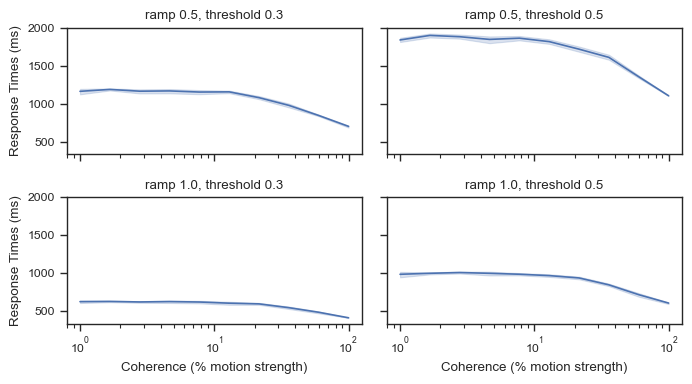

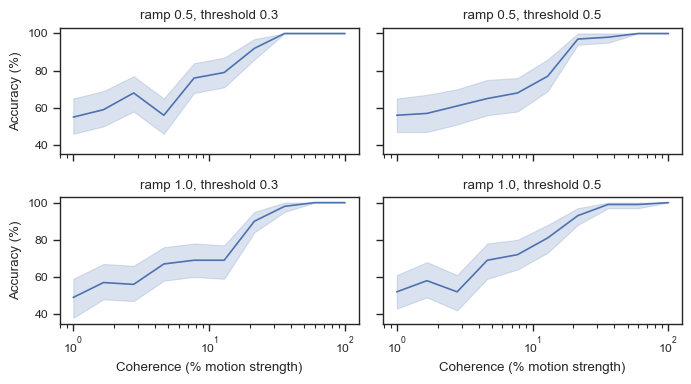

In [19]:
scan_coherence_ramp_threshold(
        coherences=np.geomspace(0.01, 1.0, 10),
        ramps=[0.5, 1.0],
        thresholds=[0.3, 0.5],
        trials=100)

trial 0, coherence 0.01, ramp 0.5, threshold 0.3
trial 1, coherence 0.01, ramp 0.5, threshold 0.3
trial 2, coherence 0.01, ramp 0.5, threshold 0.3
trial 3, coherence 0.01, ramp 0.5, threshold 0.3
trial 4, coherence 0.01, ramp 0.5, threshold 0.3
trial 5, coherence 0.01, ramp 0.5, threshold 0.3
trial 6, coherence 0.01, ramp 0.5, threshold 0.3
trial 7, coherence 0.01, ramp 0.5, threshold 0.3
trial 8, coherence 0.01, ramp 0.5, threshold 0.3
trial 9, coherence 0.01, ramp 0.5, threshold 0.3
trial 10, coherence 0.01, ramp 0.5, threshold 0.3
trial 11, coherence 0.01, ramp 0.5, threshold 0.3
trial 12, coherence 0.01, ramp 0.5, threshold 0.3
trial 13, coherence 0.01, ramp 0.5, threshold 0.3
trial 14, coherence 0.01, ramp 0.5, threshold 0.3
trial 15, coherence 0.01, ramp 0.5, threshold 0.3
trial 16, coherence 0.01, ramp 0.5, threshold 0.3
trial 17, coherence 0.01, ramp 0.5, threshold 0.3
trial 18, coherence 0.01, ramp 0.5, threshold 0.3
trial 19, coherence 0.01, ramp 0.5, threshold 0.3
trial 20, 

trial 13, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 14, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 15, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 16, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 17, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 18, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 19, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 20, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 21, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 22, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 23, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 24, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 25, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 26, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 27, coherence 0.0774263682681127, ramp 0.5, threshold 0.3
trial 28, coherence 0.0774263682681127, 

trial 22, coherence 0.5994842503189409, ramp 0.5, threshold 0.3
trial 23, coherence 0.5994842503189409, ramp 0.5, threshold 0.3
trial 24, coherence 0.5994842503189409, ramp 0.5, threshold 0.3
trial 25, coherence 0.5994842503189409, ramp 0.5, threshold 0.3
trial 26, coherence 0.5994842503189409, ramp 0.5, threshold 0.3
trial 27, coherence 0.5994842503189409, ramp 0.5, threshold 0.3
trial 28, coherence 0.5994842503189409, ramp 0.5, threshold 0.3
trial 29, coherence 0.5994842503189409, ramp 0.5, threshold 0.3
trial 0, coherence 1.0, ramp 0.5, threshold 0.3
trial 1, coherence 1.0, ramp 0.5, threshold 0.3
trial 2, coherence 1.0, ramp 0.5, threshold 0.3
trial 3, coherence 1.0, ramp 0.5, threshold 0.3
trial 4, coherence 1.0, ramp 0.5, threshold 0.3
trial 5, coherence 1.0, ramp 0.5, threshold 0.3
trial 6, coherence 1.0, ramp 0.5, threshold 0.3
trial 7, coherence 1.0, ramp 0.5, threshold 0.3
trial 8, coherence 1.0, ramp 0.5, threshold 0.3
trial 9, coherence 1.0, ramp 0.5, threshold 0.3
trial 10

trial 13, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 14, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 15, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 16, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 17, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 18, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 19, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 20, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 21, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 22, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 23, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 24, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 25, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 26, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 27, coherence 0.046415888336127774, ramp 0.5, threshold 0.5
trial 28, 

trial 21, coherence 0.3593813663804626, ramp 0.5, threshold 0.5
trial 22, coherence 0.3593813663804626, ramp 0.5, threshold 0.5
trial 23, coherence 0.3593813663804626, ramp 0.5, threshold 0.5
trial 24, coherence 0.3593813663804626, ramp 0.5, threshold 0.5
trial 25, coherence 0.3593813663804626, ramp 0.5, threshold 0.5
trial 26, coherence 0.3593813663804626, ramp 0.5, threshold 0.5
trial 27, coherence 0.3593813663804626, ramp 0.5, threshold 0.5
trial 28, coherence 0.3593813663804626, ramp 0.5, threshold 0.5
trial 29, coherence 0.3593813663804626, ramp 0.5, threshold 0.5
trial 0, coherence 0.5994842503189409, ramp 0.5, threshold 0.5
trial 1, coherence 0.5994842503189409, ramp 0.5, threshold 0.5
trial 2, coherence 0.5994842503189409, ramp 0.5, threshold 0.5
trial 3, coherence 0.5994842503189409, ramp 0.5, threshold 0.5
trial 4, coherence 0.5994842503189409, ramp 0.5, threshold 0.5
trial 5, coherence 0.5994842503189409, ramp 0.5, threshold 0.5
trial 6, coherence 0.5994842503189409, ramp 0.

trial 13, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 14, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 15, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 16, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 17, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 18, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 19, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 20, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 21, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 22, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 23, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 24, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 25, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 26, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 27, coherence 0.027825594022071243, ramp 1.0, threshold 0.3
trial 28, 

trial 20, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 21, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 22, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 23, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 24, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 25, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 26, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 27, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 28, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 29, coherence 0.21544346900318834, ramp 1.0, threshold 0.3
trial 0, coherence 0.3593813663804626, ramp 1.0, threshold 0.3
trial 1, coherence 0.3593813663804626, ramp 1.0, threshold 0.3
trial 2, coherence 0.3593813663804626, ramp 1.0, threshold 0.3
trial 3, coherence 0.3593813663804626, ramp 1.0, threshold 0.3
trial 4, coherence 0.3593813663804626, ramp 1.0, threshold 0.3
trial 5, coherence 0.35938136638046

trial 12, coherence 0.016681005372000592, ramp 1.0, threshold 0.5
trial 13, coherence 0.016681005372000592, ramp 1.0, threshold 0.5
trial 14, coherence 0.016681005372000592, ramp 1.0, threshold 0.5
trial 15, coherence 0.016681005372000592, ramp 1.0, threshold 0.5
trial 16, coherence 0.016681005372000592, ramp 1.0, threshold 0.5
trial 17, coherence 0.016681005372000592, ramp 1.0, threshold 0.5
trial 18, coherence 0.016681005372000592, ramp 1.0, threshold 0.5
trial 19, coherence 0.016681005372000592, ramp 1.0, threshold 0.5
trial 20, coherence 0.016681005372000592, ramp 1.0, threshold 0.5
trial 21, coherence 0.016681005372000592, ramp 1.0, threshold 0.5
trial 22, coherence 0.016681005372000592, ramp 1.0, threshold 0.5
trial 23, coherence 0.016681005372000592, ramp 1.0, threshold 0.5
trial 24, coherence 0.016681005372000592, ramp 1.0, threshold 0.5
trial 25, coherence 0.016681005372000592, ramp 1.0, threshold 0.5
trial 26, coherence 0.016681005372000592, ramp 1.0, threshold 0.5
trial 27, 

trial 19, coherence 0.1291549665014884, ramp 1.0, threshold 0.5
trial 20, coherence 0.1291549665014884, ramp 1.0, threshold 0.5
trial 21, coherence 0.1291549665014884, ramp 1.0, threshold 0.5
trial 22, coherence 0.1291549665014884, ramp 1.0, threshold 0.5
trial 23, coherence 0.1291549665014884, ramp 1.0, threshold 0.5
trial 24, coherence 0.1291549665014884, ramp 1.0, threshold 0.5
trial 25, coherence 0.1291549665014884, ramp 1.0, threshold 0.5
trial 26, coherence 0.1291549665014884, ramp 1.0, threshold 0.5
trial 27, coherence 0.1291549665014884, ramp 1.0, threshold 0.5
trial 28, coherence 0.1291549665014884, ramp 1.0, threshold 0.5
trial 29, coherence 0.1291549665014884, ramp 1.0, threshold 0.5
trial 0, coherence 0.21544346900318834, ramp 1.0, threshold 0.5
trial 1, coherence 0.21544346900318834, ramp 1.0, threshold 0.5
trial 2, coherence 0.21544346900318834, ramp 1.0, threshold 0.5
trial 3, coherence 0.21544346900318834, ramp 1.0, threshold 0.5
trial 4, coherence 0.21544346900318834, 

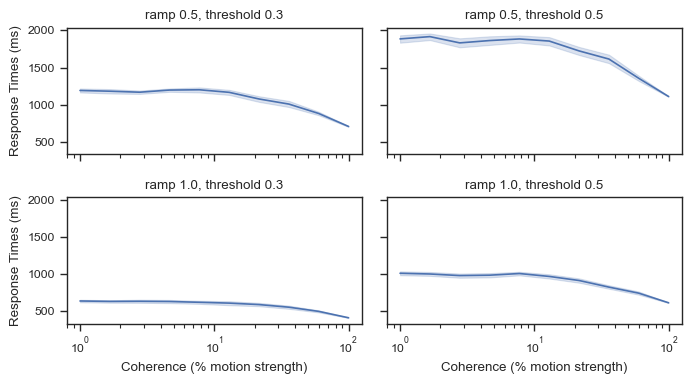

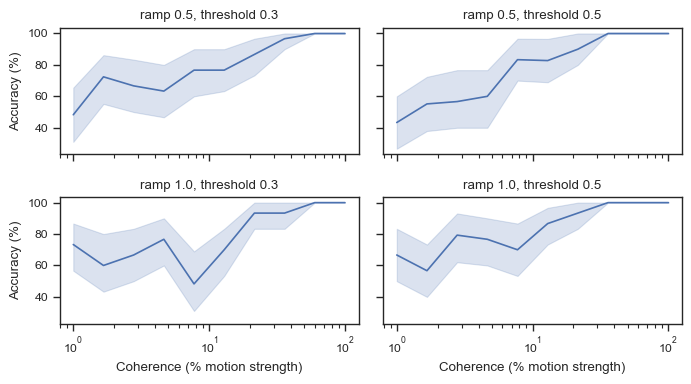

In [42]:
scan_coherence_ramp_threshold(
        coherences=np.geomspace(0.01, 1.0, 10),
        ramps=[0.5, 1.0],
        thresholds=[0.3, 0.5],
        trials=30,
        load=False,
        errbar="ci",
        name="2thresh_2ramp")

In [25]:
data = pd.read_pickle("data/scan_coherence_ramp_threshold.pkl")
d2 = data.query("ramp==1 & threshold==0.5 & coherence==1.0")
RTs = d2['RT'].to_numpy()

<Axes: xlabel='RT', ylabel='Count'>

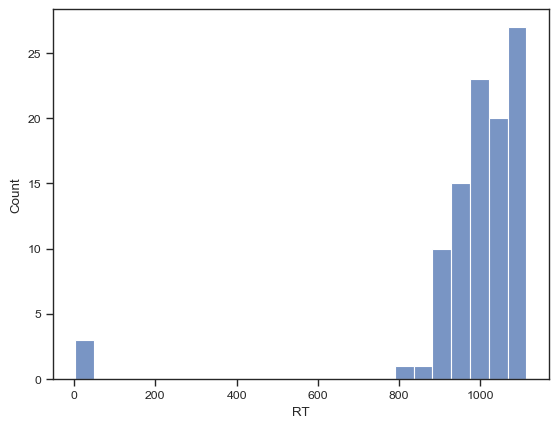

In [31]:
fig, ax = plt.subplots()
sns.histplot(data=d2, x='RT')